In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd 
from scipy.optimize import minimize


In [2]:
ODMR_DATA_raw=pd.read_csv('ODMR_Contrast_Optimization.csv')

In [3]:
ODMR_DATA = ODMR_DATA_raw.to_numpy()
np.shape(ODMR_DATA)

(20000, 5120)

In [28]:
len(ODMR_DATA[0])

5120

In [4]:
DATA_mean=np.mean(ODMR_DATA,axis=1)


In [5]:
sig=DATA_mean[::2]
bg=DATA_mean[1::2]


In [6]:
awg_parameters = {
    "seq": "CW ODMR",
    "i_offset": -2*1e-3, #mV
    "q_offset": -4*1e-3, #mV
    "probe_length": 20*1e-6, #us
    "sideband_power": 150 * 1e-3, #mV
    "sideband_freqs": None, #MHz
    "iq_phases": [0,90],
    "num_pts": 40,
    "max_sideband" : 40*1e6,
    'runs':1000}

awg_parameters['sideband_freqs']=np.linspace(0,awg_parameters["max_sideband"],awg_parameters['num_pts'])
# print(awg_parameters)

In [7]:
sig_mean=np.zeros(awg_parameters['num_pts'])
bg_mean=np.zeros(awg_parameters['num_pts'])
for i in range(awg_parameters['runs']):
    for j in range(0,awg_parameters['num_pts']):
        sig_mean[j]+=np.mean(sig[j::awg_parameters['num_pts']])
        bg_mean[j]+=np.mean(bg[j::awg_parameters['num_pts']])

In [8]:
freq=np.flip(2.34e9-awg_parameters['sideband_freqs'])


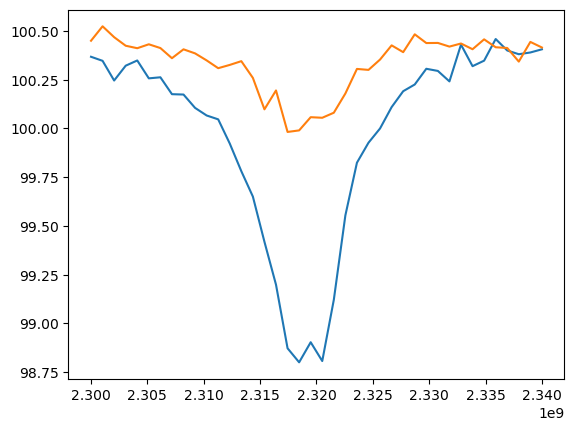

In [9]:
plt.plot(freq,sig_mean)
plt.plot(freq,bg_mean)


In [10]:
def contrast_math(data):
    data_mean=np.mean(data,axis=1)
    sig=data_mean[::2]
    bg=data_mean[1::2]
    sig_mean=np.zeros(awg_parameters['num_pts'])
    bg_mean=np.zeros(awg_parameters['num_pts'])
    for i in range(awg_parameters['runs']):
        for j in range(0,awg_parameters['num_pts']):
            sig_mean[j]+=np.mean(sig[j::awg_parameters['num_pts']])
            bg_mean[j]+=np.mean(bg[j::awg_parameters['num_pts']])
    return(sig_mean,bg_mean)

def contrast_val(data):
    sig, bg = contrast_math(data)
    max_contrast=np.max((bg-sig)/sig)
    return max_contrast

In [11]:
A,B = contrast_math(ODMR_DATA)

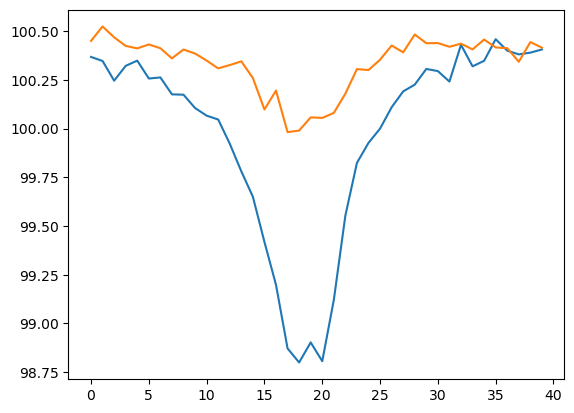

In [12]:
plt.plot(A)
plt.plot(B)

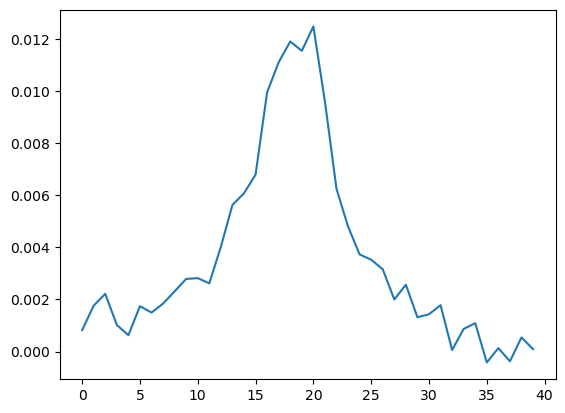

In [13]:
plt.plot((B-A)/B)

In [14]:
def contrast_math(data,start,stop):
    sliced_data=data[:, start:stop]
    data_mean=np.mean(sliced_data,axis=1)
    sig=data_mean[::2]
    bg=data_mean[1::2]
    sig_mean=np.zeros(awg_parameters['num_pts'])
    bg_mean=np.zeros(awg_parameters['num_pts'])
    for i in range(awg_parameters['runs']):
        for j in range(0,awg_parameters['num_pts']):
            sig_mean[j]+=np.mean(sig[j::awg_parameters['num_pts']])
            bg_mean[j]+=np.mean(bg[j::awg_parameters['num_pts']])
    return(sig_mean,bg_mean)

def contrast_val(data):
    sig, bg = contrast_math(data)
    max_contrast=np.max((bg-sig)/sig)
    return max_contrast

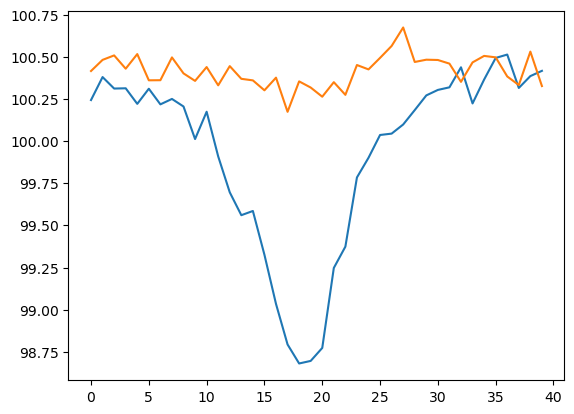

In [53]:
A,B = contrast_math(ODMR_DATA,4000,5120)
plt.plot(A)
plt.plot(B)


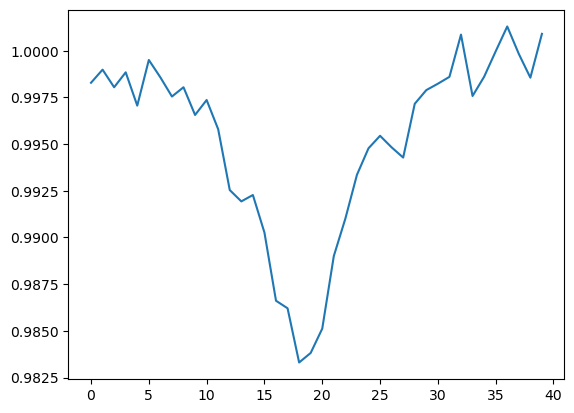

In [54]:
plt.plot((A/B))

In [61]:
def optimize(params):
    start, stop = int(params[0]), int(params[1])
    data=ODMR_DATA
    sliced_data=data[:, start:stop]
    data_mean=np.mean(sliced_data,axis=1)
    sig=data_mean[::2]
    bg=data_mean[1::2]
    sig_mean=np.zeros(awg_parameters['num_pts'])
    bg_mean=np.zeros(awg_parameters['num_pts'])
    for i in range(awg_parameters['runs']):
        for j in range(0,awg_parameters['num_pts']):
            sig_mean[j]+=np.mean(sig[j::awg_parameters['num_pts']])
            bg_mean[j]+=np.mean(bg[j::awg_parameters['num_pts']])
    max_contrast=np.max((bg_mean-sig_mean)/sig_mean)
    return(-max_contrast)

In [67]:
x0 = [0, 5120]  # Starting point


# Bounds (if any)
bounds = [(0, 5120), (0, 5120)]  # Example: Bounds on x[0] and x[1]

# Perform the optimization
result = minimize(
    optimize, 
    x0, 
    bounds=bounds
)

# Print the results
if result.success:
    print(f"Optimization successful: {result.message}")
    print(f"Optimal parameters: {result.x}")
    print(f"Objective function value at optimum: {result.fun}")
else:
    print("Optimization failed:", result.message)


Optimization successful: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
Optimal parameters: [   0.         5119.99999618]
Objective function value at optimum: -0.012639153719666134


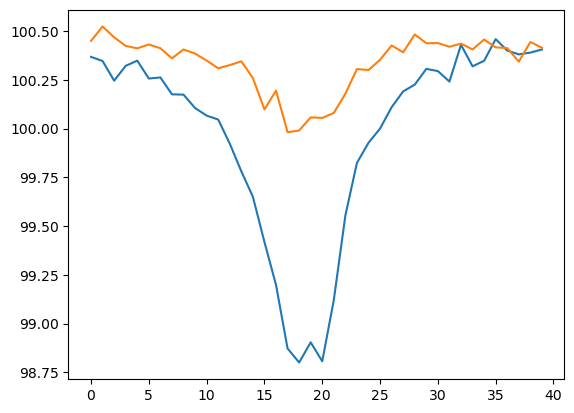

In [68]:
A,B = contrast_math(ODMR_DATA,int(result.x[0]),int(result.x[1]))
plt.plot(A)
plt.plot(B)

In [69]:
from scipy.optimize import minimize, differential_evolution

# Define the objective function (maximize contrast)
def optimize(params):
    start, stop = int(params[0]), int(params[1])
    data = ODMR_DATA
    sliced_data = data[:, start:stop]
    data_mean = np.mean(sliced_data, axis=1)
    sig = data_mean[::2]
    bg = data_mean[1::2]
    sig_mean = np.zeros(awg_parameters['num_pts'])
    bg_mean = np.zeros(awg_parameters['num_pts'])
    
    for i in range(awg_parameters['runs']):
        for j in range(0, awg_parameters['num_pts']):
            sig_mean[j] += np.mean(sig[j::awg_parameters['num_pts']])
            bg_mean[j] += np.mean(bg[j::awg_parameters['num_pts']])
    
    max_contrast = np.max((bg_mean - sig_mean) / sig_mean)
    return -max_contrast  # Minimizing negative contrast

# Define the bounds for the parameters (if any)
bounds = [(0, 5120), (0, 5120)]  # Example: Bounds on start and stop parameters

# Perform the optimization using Differential Evolution for global optimization
result = differential_evolution(
    optimize, 
    bounds, 
    maxiter=1000,  # Maximum number of iterations
    popsize=15,  # Population size for the algorithm
    recombination=0.7,  # Recombination factor
    seed=42  # Random seed for reproducibility
)

# Print the results
if result.success:
    print(f"Optimization successful: {result.message}")
    print(f"Optimal parameters: {result.x}")
    print(f"Objective function value at optimum: {result.fun}")
else:
    print("Optimization failed:", result.message)


c:\Users\ejvil\miniconda3\envs\nspyre\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ejvil\miniconda3\envs\nspyre\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


ValueError: cannot convert float NaN to integer